# TREINAMENTO REDE KCL-CNN-AUGMENTATION V2.4KCL.70e.2CLe

**Rede:** KCL-CNN Editada COM Augmentation
> Sem uma Conv2D, MaxPooling2D e Dropout

> Adição de camadas de Augmentation COM RANDOM INVERT

> Divisão nº 2

**Dataset:** Cleaned Localized Equilibrado

> Epochs = 70

> Batch = 512

> Target = (100, 100)

> SEED = 10

> DATA AUGMENTATION? Sim

> CLUSTERIZAÇÃO? Não

**Obs.:** Com separação de indivíduo

In [1]:
!nvidia-smi

Tue Oct  1 04:58:31 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
os.environ['TF_DISABLE_JIT'] = '1'

In [3]:
!jupyter notebook --NotebookApp.iopub_msg_rate_limit=1.0e10

[I 04:58:35.029 NotebookApp] [nb_conda_kernels] enabled, 1 kernels found
[I 04:58:35.109 NotebookApp] Writing notebook server cookie secret to /root/.local/share/jupyter/runtime/notebook_cookie_secret

  _   _          _      _
 | | | |_ __  __| |__ _| |_ ___
 | |_| | '_ \/ _` / _` |  _/ -_)
  \___/| .__/\__,_\__,_|\__\___|
       |_|
                       
Read the migration plan to Notebook 7 to learn about the new features and the actions to take if you are using extensions.

https://jupyter-notebook.readthedocs.io/en/latest/migrate_to_notebook7.html

Please note that updating to Notebook 7 might break some of your extensions.

[I 04:58:35.459 NotebookApp] Registered dataproc_jupyter_plugin server extension
jupyter_http_over_ws extension initialized. Listening on /http_over_websocket
[I 04:58:35.844 NotebookApp] Skipped non-installed server(s): bash-language-server, dockerfile-language-server-nodejs, javascript-typescript-langserver, jedi-language-server, julia-language-server, pyr

## Bibliotecas e Constantes

In [4]:
#!pip install tensorflow[and-cuda]

In [5]:
#------------------------------------------------------------------------------
# BIBLIOTECAS

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import sys
import random

# BIBLIOTECAS DEEP LEARNING
import datetime
import tensorflow as tf
import tensorflow.keras.layers as layers
from sklearn.metrics import auc, classification_report, confusion_matrix, roc_curve
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing import image

#------------------------------------------------------------------------------
# CONSTANTES

DATASET_TYPE = ['cleaned', 'selected-localized', 'cleaned-localized']
DATASET_TYPE = DATASET_TYPE[0] # Dataset utilizado no treinamento

DATASET_COMPLETO = False

CNN_MODEL = 'kcl-cnn-augmentation' # Rede utilizada no treinamento

SEED = 10
np.random.seed(SEED) # semente geradora dos numeros aleatorios
random.seed(SEED)
tf.random.set_seed(SEED)

N_FOLDS = 5
N_EPOCHS = 70
BATCH_SIZE = 512
SIZE = 100
TARGET_SIZE = (SIZE, SIZE)

VERSION = '2.4KCL.70e.2CLe'

2024-10-01 04:58:42.604454: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-01 04:58:42.604589: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-01 04:58:42.754723: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Diretórios e Carregamentos de Dados

In [6]:
# Criando pasta de resultados
if not os.path.exists(f'{DATASET_TYPE}'):
    os.mkdir(f'{DATASET_TYPE}')

In [7]:
#------------------------------------------------------------------------------
# DIRETÓRIOS DOS DATASETS

DATASET_PATH = f'/kaggle/input/myocardit-dataset-cleaned-localized'
RESULTS_PATH = f'/kaggle/working/{DATASET_TYPE}'

NORMAL_PATH = DATASET_PATH + '/Normal/'
SICK_PATH = DATASET_PATH + '/Sick/'

# Diretorios de cada Individuo:
normal_datasets = [f'{NORMAL_PATH}Individuo_{i:02}/' for i in range(1, 17)]
sick_datasets = [f'{SICK_PATH}Individuo_{i:02}/' for i in range(1, 31)]

print(normal_datasets)
print(sick_datasets)

NORMAL_SPLITS = [[2, 10, 14],
                 [4, 7, 13],
                 [6, 8, 11, 15, 16],
                 [1, 5],
                 [3, 3, 12]]

#Grupo 1: ['Individuo_2', 'Individuo_10', 'Individuo_14'], Soma: 1334.0
#Grupo 2: ['Individuo_4', 'Individuo_7', 'Individuo_13'], Soma: 1342.0
#Grupo 3: ['Individuo_6', 'Individuo_8', 'Individuo_11', 'Individuo_15', 'Individuo_16'], Soma: 1339.0
#Grupo 4: ['Individuo_1', 'Individuo_5'], Soma: 1321.0
#Grupo 5: ['Individuo_3', 'Individuo_9', 'Individuo_12'], Soma: 1339.0
#Soma total: 6675.0, Média por grupo: 1335.0

if DATASET_COMPLETO == True:
    SICK_SPLITS = [[18, 29, 32, 35, 41, 43, 45],
                   [19, 20, 27, 34, 42],
                   [17, 23, 30, 33, 38],
                   [22, 28, 31, 36, 37, 40, 44, 47],
                   [21, 24, 25, 25, 39, 46]]
    
#Grupo 1: ['Individuo_18', 'Individuo_29', 'Individuo_32', 'Individuo_35', 'Individuo_41', 'Individuo_43', 'Individuo_45'], Soma: 2637.0
#Grupo 2: ['Individuo_19', 'Individuo_20', 'Individuo_27', 'Individuo_34', 'Individuo_42'], Soma: 2636.0
#Grupo 3: ['Individuo_17', 'Individuo_23', 'Individuo_30', 'Individuo_33', 'Individuo_38'], Soma: 2637.0
#Grupo 4: ['Individuo_22', 'Individuo_28', 'Individuo_31', 'Individuo_36', 'Individuo_37', 'Individuo_40', 'Individuo_44', 'Individuo_47'], Soma: 2637.0
#Grupo 5: ['Individuo_21', 'Individuo_24', 'Individuo_25', 'Individuo_26', 'Individuo_39', 'Individuo_46'], Soma: 2636.0
#Soma total: 13183.0, Média por grupo: 2636.6
    
else:
    SICK_SPLITS = [[24, 33, 35, 41],
                   [25, 32, 36, 42],
                   [26, 31, 37, 43],
                   [27, 30, 39, 45],
                   [28, 29, 38, 44]]
    
#Grupo 1: ['Individuo_24', 'Individuo_33', 'Individuo_35', 'Individuo_41'], Soma: 1348.0
#Grupo 2: ['Individuo_25', 'Individuo_32', 'Individuo_36', 'Individuo_42'], Soma: 1369.0
#Grupo 3: ['Individuo_26', 'Individuo_31', 'Individuo_37', 'Individuo_43'], Soma: 1401.0
#Grupo 4: ['Individuo_27', 'Individuo_30', 'Individuo_39', 'Individuo_45'], Soma: 1430.0
#Grupo 5: ['Individuo_28', 'Individuo_29', 'Individuo_38', 'Individuo_44'], Soma: 1429.0
#Média das somas dos grupos: 1395.40
    
normal_splits = [[],[],[],[],[]]
sick_splits = [[],[],[],[],[]]

for split in range(N_FOLDS):
    normal_splits[split].extend(normal_datasets[i-1] for i in NORMAL_SPLITS[split])
    sick_splits[split].extend(sick_datasets[i-17] for i in SICK_SPLITS[split])

['/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_01/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_02/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_03/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_04/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_05/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_06/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_07/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_08/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_09/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_10/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_11/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_12/', '/kaggle/input/myocardit-dataset-cleaned-localized/Normal/Individuo_13/', '/kaggle/input/myocardit-dataset-clea

In [8]:
#------------------------------------------------------------------------------
# CARREGAMENTO DE DADOS COM SEPARAÇÃO DE INDIVIDUOS

print('\nIniciando carregamento e processamento das imagens..............!')

def carregar_imagens(diretorio):
    global num_imagens
    imagens = []
    for pasta_atual, subpastas, arquivos in os.walk(diretorio):
        for arquivo in arquivos:
            if arquivo.endswith(('.jpg', '.jpeg', '.png')):
                caminho = os.path.join(pasta_atual, arquivo)
                
                img = Image.open(caminho)
                img = img.resize(TARGET_SIZE)
                img = img.convert('L')
                img_array = np.array(img)
                imagens.append(img_array)
                
                num_imagens += 1
                sys.stdout.write("\rNumero de imagens carregados: %i" % num_imagens)
                sys.stdout.flush()
                
    return imagens

num_imagens = 0

print('\nPacientes normais:')
normal_groups = []
for diretorios in normal_splits:
    imagens = []
    for individuos in diretorios:
        imagens.extend(carregar_imagens(individuos))
    normal_groups.append(imagens)

num_imagens = 0

print('\n\nPacientes doentes:')
sick_groups = []
for diretorios in sick_splits:
    imagens = []
    for individuos in diretorios:
        imagens.extend(carregar_imagens(individuos))
    sick_groups.append(imagens)

# DATASETS SEPRADAOS EM 5 PARA VALIDAÇÃO CRUZADA    
x_data = [[],[],[],[],[]]
y_data = [[],[],[],[],[]]

print('\n\nNumero de imagens por split:')
for i in range(N_FOLDS):
    x_data[i].extend(path for path in normal_groups[i])
    y_data[i].extend([1, 0] for path in normal_groups[i])
    x_data[i].extend(path for path in sick_groups[i])
    y_data[i].extend([0, 1] for path in sick_groups[i])
    print(f'Split {i+1}: {len(x_data[i])} imagens ({len(normal_groups[i])} saudáveis e {len(sick_groups[i])} doentes).')


Iniciando carregamento e processamento das imagens..............!

Pacientes normais:
Numero de imagens carregados: 7009

Pacientes doentes:
Numero de imagens carregados: 6977

Numero de imagens por split:
Split 1: 2682 imagens (1334 saudáveis e 1348 doentes).
Split 2: 2711 imagens (1342 saudáveis e 1369 doentes).
Split 3: 2740 imagens (1339 saudáveis e 1401 doentes).
Split 4: 2751 imagens (1321 saudáveis e 1430 doentes).
Split 5: 3102 imagens (1673 saudáveis e 1429 doentes).


## Treinamento

In [9]:
import tensorflow as tf
from tensorflow.keras import layers

def random_invert_img(x, factor):
    """Função para aplicar inversão e contraste de forma condicional."""
    return tf.cond(
        tf.less(tf.random.uniform([]), factor),  # Se tf.random.uniform for menor que o fator
        lambda: tf.image.adjust_contrast((1 - x) - 0.6, 1.0),  # Aplica a inversão e ajusta o contraste
        lambda: x  # Caso contrário, retorna a imagem original
    )

def random_invert_layer(factor):
    """Camada personalizada para inversão de imagem com especificação de output_shape."""
    return layers.Lambda(lambda x: random_invert_img(x, factor), output_shape=lambda s: s)

def cnn_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    # Aumentação de dados
    x = layers.RandomFlip("horizontal_and_vertical")(inputs)
    x = layers.RandomRotation(0.2)(x)
    x = layers.RandomContrast(0.5)(x)
    x = layers.RandomZoom(0.2)(x)
    
    # Aplicação de inversão personalizada
    x = random_invert_layer(0.5)(x)
    
    # Camadas convolucionais
    x = layers.Conv2D(8, 3, activation='relu')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(16, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Flatten()(x)
    
    # Camadas densas
    x = layers.Dense(25, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    # Criação do modelo
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.summary()
    return model

In [10]:
#------------------------------------------------------------------------------
# SEPARAÇÃO DE DADOS E TREINAMENTO

lst_accuracy=[]
lst_accuracy_v=[]
lst_accuracy_train=[]
lst_acc=[]
lst_loss=[]
lst_reports=[]
lst_AUC=[]
lst_matrix=[]
lst_matrix_v=[]
lst_matrix_train=[]
lst_times=[]
lst_history=[]


#------------------------------------------------------------------------------
# TREINAMENTO POR FOLDS

for fold in range(N_FOLDS):

    print(f'\n\nFOLD {fold+1}:')

    #--------------------------------------------------------------------------
    # Carregamento dos dados de treinamento, validação e teste
    
    x_test = np.array(x_data[fold])
    y_test = np.array(y_data[fold])
    
    folds = [0, 1, 2, 3, 4]
    folds.remove(fold)

    x_valid = np.array(x_data[folds[0]])
    y_valid = np.array(y_data[folds[0]])
    folds.remove(folds[0])

    x_train, y_train = [], []
    for i in folds:
        x_train.extend(x_data[i])
        y_train.extend(y_data[i])
    x_train = np.array(x_train)
    y_train = np.array(y_train)

    print(f'Numero de imagens no treinamento: {len(x_train)} imagens.')
    print(f'Numero de imagens na validação: {len(x_valid)} imagens.')
    print(f'Numero de imagens no teste: {len(x_test)} imagens.')

    #--------------------------------------------------------------------------
    # Arquitetura e compilação

    model = cnn_model((SIZE, SIZE, 1), 2)
    
    OPTIMIZER = AdamW(weight_decay=0.004)
    
    # Compilação do modelo
    model.compile(loss='categorical_crossentropy',
                  optimizer=OPTIMIZER,
                  metrics=['categorical_accuracy'])

    #--------------------------------------------------------------------------
    # Treinamento
    
    print('\nIniciando o treinamento.........................................!\n')

    calback = CSVLogger(RESULTS_PATH + f'/logger_fold{fold+1}.log')

    # Treinamento com augmentação
    start = datetime.datetime.now()

    history = model.fit(x_train, y_train,
                        batch_size=BATCH_SIZE,
                        epochs=N_EPOCHS,
                        validation_data=(x_valid, y_valid),
                        callbacks=[calback])

    end = datetime.datetime.now()
    training_time = end - start

    # Salvando o modelo
    model.save(RESULTS_PATH + f'/{DATASET_TYPE}-CNN-{fold+1}.keras')

    #--------------------------------------------------------------------------
    # Teste
    print("\nTestando imagens................................................!\n")
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print(model.metrics_names)

    #--------------------------------------------------------------------------
    # ARMAZENAMENTO DOS INFORMACOES

    # Fazendo previsões
    predicts = model.predict(x_test)
    predicts = predicts.argmax(axis=1)

    # Obtendo os rótulos verdadeiros
    actuals=y_test.argmax(axis=1)

    # Calculando a curva ROC
    fpr, tpr, _ = roc_curve(actuals, predicts, pos_label=1)
    a = auc(fpr, tpr)

    # Gerando o relatório de classificação
    r = classification_report(actuals, predicts, zero_division=1)

    # Calculando a matriz de confusão
    c = confusion_matrix(actuals, predicts)
    accuracy = np.trace(c)/np.sum(c)
    
    # Validação
    # Fazendo previsões
    predicts_v = model.predict(x_valid)
    predicts_v = predicts_v.argmax(axis=1)

    # Obtendo os rótulos verdadeiros
    actuals_v=y_valid.argmax(axis=1)
    
    # Calculando a matriz de confusão
    c_v = confusion_matrix(actuals_v, predicts_v)
    accuracy_v = np.trace(c_v)/np.sum(c_v)
    
    # Treino
    # Fazendo previsões
    predicts_train = model.predict(x_train)
    predicts_train = predicts_train.argmax(axis=1)

    # Obtendo os rótulos verdadeiros
    actuals_train=y_train.argmax(axis=1)
    
    # Calculando a matriz de confusão
    c_train = confusion_matrix(actuals_train, predicts_train)
    accuracy_train = np.trace(c_train)/np.sum(c_train)

    lst_history.append(history)
    lst_times.append(training_time)
    lst_accuracy.append(accuracy)
    lst_acc.append(test_acc)
    lst_loss.append(test_loss)
    lst_AUC.append(a)
    lst_reports.append(r)
    lst_matrix.append(c)
    
    lst_accuracy_v.append(accuracy_v)
    lst_matrix_v.append(c_v)
    
    lst_accuracy_train.append(accuracy_train)
    lst_matrix_train.append(c_train)



FOLD 1:
Numero de imagens no treinamento: 8593 imagens.
Numero de imagens na validação: 2711 imagens.
Numero de imagens no teste: 2682 imagens.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 100, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 98, 98, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 49, 49, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 23, 23, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8464)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │       211,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,925 (831.74 KB)

 Trainable params: 212,925 (831.74 KB)

 Non-trainable params: 0 (0.00 B)


Iniciando o treinamento.........................................!

Epoch 1/70
 3/17 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.5163 - loss: 107.0749

I0000 00:00:1727758812.213770     102 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1727758812.235335     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - categorical_accuracy: 0.5093 - loss: 65.6483

W0000 00:00:1727758819.868059     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1727758820.518374     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 574ms/step - categorical_accuracy: 0.5091 - loss: 63.7079 - val_categorical_accuracy: 0.5050 - val_loss: 0.6931
Epoch 2/70
 5/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - categorical_accuracy: 0.5102 - loss: 0.6931

W0000 00:00:1727758821.466254     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - categorical_accuracy: 0.4982 - loss: 0.6932 - val_categorical_accuracy: 0.5050 - val_loss: 0.6931
Epoch 3/70
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - categorical_accuracy: 0.4982 - loss: 0.6932 - val_categorical_accuracy: 0.5050 - val_loss: 0.6931
Epoch 4/70
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - categorical_accuracy: 0.4982 - loss: 0.6932 - val_categorical_accuracy: 0.5050 - val_loss: 0.6931
Epoch 5/70
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - categorical_accuracy: 0.4982 - loss: 0.6932 - val_categorical_accuracy: 0.5050 - val_loss: 0.6931
Epoch 6/70
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - categorical_accuracy: 0.4982 - loss: 0.6932 - val_categorical_accuracy: 0.5050 - val_loss: 0.6931
Epoch 7/70
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - categorical_accuracy: 0.4982 - loss: 0.6932 - val_categorical_accuracy: 0.5050 - val_loss: 0.6931
Epoch 8/70
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - categorical_accuracy: 0.4982 - loss: 0.6932 - val_ca

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100, 100, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 98, 98, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 49, 49, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 49, 49, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 47, 47, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 23, 23, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 23, 23, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8464)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │       211,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,925 (831.74 KB)

 Trainable params: 212,925 (831.74 KB)

 Non-trainable params: 0 (0.00 B)


Iniciando o treinamento.........................................!

Epoch 1/70
 4/17 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.4917 - loss: 80.5228

W0000 00:00:1727758870.425553     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - categorical_accuracy: 0.5014 - loss: 44.2467

W0000 00:00:1727758874.815692     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1727758875.453169     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step - categorical_accuracy: 0.5015 - loss: 42.8543 - val_categorical_accuracy: 0.4974 - val_loss: 0.6932
Epoch 2/70
 5/17 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_accuracy: 0.4898 - loss: 0.6932

W0000 00:00:1727758876.354513     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - categorical_accuracy: 0.5018 - loss: 0.6931 - val_categorical_accuracy: 0.4974 - val_loss: 0.6932
Epoch 3/70
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - categorical_accuracy: 0.5018 - loss: 0.6931 - val_categorical_accuracy: 0.4974 - val_loss: 0.6932
Epoch 4/70
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - categorical_accuracy: 0.5018 - loss: 0.6931 - val_categorical_accuracy: 0.4974 - val_loss: 0.6932
Epoch 5/70
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - categorical_accuracy: 0.5018 - loss: 0.6931 - val_categorical_accuracy: 0.4974 - val_loss: 0.6932
Epoch 6/70
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - categorical_accuracy: 0.5018 - loss: 0.6931 - val_categorical_accuracy: 0.4974 - val_loss: 0.6932
Epoch 7/70
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - categorical_accuracy: 0.5018 - loss: 0.6931 - val_categorical_accuracy: 0.4974 - val_loss: 0.6932
Epoch 8/70
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - categorical_accuracy: 0.5018 - loss: 0.6931 - val_ca

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 100, 100, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 98, 98, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 49, 49, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 49, 49, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 47, 47, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 23, 23, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 23, 23, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8464)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │       211,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,925 (831.74 KB)

 Trainable params: 212,925 (831.74 KB)

 Non-trainable params: 0 (0.00 B)


Iniciando o treinamento.........................................!

Epoch 1/70
 3/17 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.5280 - loss: 41.3972

W0000 00:00:1727758924.979692     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - categorical_accuracy: 0.5063 - loss: 26.2742

W0000 00:00:1727758933.041150     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1727758933.580699     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 553ms/step - categorical_accuracy: 0.5058 - loss: 25.5197 - val_categorical_accuracy: 0.5026 - val_loss: 0.6931
Epoch 2/70
 2/17 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - categorical_accuracy: 0.4873 - loss: 0.6932

W0000 00:00:1727758933.861562     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - categorical_accuracy: 0.4916 - loss: 0.6932 - val_categorical_accuracy: 0.5026 - val_loss: 0.6931
Epoch 3/70
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - categorical_accuracy: 0.4916 - loss: 0.6932 - val_categorical_accuracy: 0.5026 - val_loss: 0.6931
Epoch 4/70
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - categorical_accuracy: 0.4916 - loss: 0.6932 - val_categorical_accuracy: 0.5026 - val_loss: 0.6931
Epoch 5/70
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - categorical_accuracy: 0.4916 - loss: 0.6932 - val_categorical_accuracy: 0.5026 - val_loss: 0.6931
Epoch 6/70
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - categorical_accuracy: 0.4950 - loss: 0.6931 - val_categorical_accuracy: 0.4974 - val_loss: 0.6932
Epoch 7/70
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - categorical_accuracy: 0.5084 - loss: 0.6931 - val_categorical_accuracy: 0.4974 - val_loss: 0.6932
Epoch 8/70
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - categorical_accuracy: 0.5084 - loss: 0.6931 - val_ca

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 100, 100, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 98, 98, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 49, 49, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 49, 49, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 47, 47, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 23, 23, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 23, 23, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8464)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25)             │       211,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,925 (831.74 KB)

 Trainable params: 212,925 (831.74 KB)

 Non-trainable params: 0 (0.00 B)


Iniciando o treinamento.........................................!

Epoch 1/70
 4/17 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - categorical_accuracy: 0.5032 - loss: 80.0867

W0000 00:00:1727758983.200833     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - categorical_accuracy: 0.4953 - loss: 42.8472

W0000 00:00:1727758991.216295     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1727758991.766342     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 550ms/step - categorical_accuracy: 0.4951 - loss: 41.4831 - val_categorical_accuracy: 0.5026 - val_loss: 0.6931
Epoch 2/70


W0000 00:00:1727758992.037328     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - categorical_accuracy: 0.4909 - loss: 0.6933 - val_categorical_accuracy: 0.5026 - val_loss: 0.6931
Epoch 3/70
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - categorical_accuracy: 0.4909 - loss: 0.6932 - val_categorical_accuracy: 0.5026 - val_loss: 0.6931
Epoch 4/70
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - categorical_accuracy: 0.4909 - loss: 0.6932 - val_categorical_accuracy: 0.5026 - val_loss: 0.6931
Epoch 5/70
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - categorical_accuracy: 0.4914 - loss: 0.6932 - val_categorical_accuracy: 0.4974 - val_loss: 0.6931
Epoch 6/70
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - categorical_accuracy: 0.5091 - loss: 0.6931 - val_categorical_accuracy: 0.4974 - val_loss: 0.6932
Epoch 7/70
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - categorical_accuracy: 0.5091 - loss: 0.6931 - val_categorical_accuracy: 0.4974 - val_loss: 0.6932
Epoch 8/70
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - categorical_accuracy: 0.5091 - loss: 0.6931 - val_ca

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 100, 100, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 98, 98, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 49, 49, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 49, 49, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 47, 47, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 23, 23, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 23, 23, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 8464)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 25)             │       211,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,925 (831.74 KB)

 Trainable params: 212,925 (831.74 KB)

 Non-trainable params: 0 (0.00 B)


Iniciando o treinamento.........................................!

Epoch 1/70
 4/17 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - categorical_accuracy: 0.5116 - loss: 112.0591

W0000 00:00:1727759049.601702     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - categorical_accuracy: 0.5076 - loss: 63.9159

W0000 00:00:1727759054.883922     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1727759055.387118     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 377ms/step - categorical_accuracy: 0.5076 - loss: 62.0085 - val_categorical_accuracy: 0.5026 - val_loss: 0.6931
Epoch 2/70
 3/17 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - categorical_accuracy: 0.5163 - loss: 0.6930

W0000 00:00:1727759055.668895     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - categorical_accuracy: 0.5144 - loss: 0.6930 - val_categorical_accuracy: 0.5026 - val_loss: 0.6931
Epoch 3/70
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - categorical_accuracy: 0.5144 - loss: 0.6930 - val_categorical_accuracy: 0.5026 - val_loss: 0.6931
Epoch 4/70
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - categorical_accuracy: 0.5144 - loss: 0.6930 - val_categorical_accuracy: 0.5026 - val_loss: 0.6931
Epoch 5/70
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - categorical_accuracy: 0.5144 - loss: 0.6929 - val_categorical_accuracy: 0.5026 - val_loss: 0.6931
Epoch 6/70
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - categorical_accuracy: 0.5144 - loss: 0.6929 - val_categorical_accuracy: 0.5026 - val_loss: 0.6931
Epoch 7/70
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - categorical_accuracy: 0.5144 - loss: 0.6929 - val_categorical_accuracy: 0.5026 - val_loss: 0.6931
Epoch 8/70
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - categorical_accuracy: 0.5144 - loss: 0.6929 - val_ca

W0000 00:00:1727759098.981340     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


## Salvamento de Dados

In [11]:
#--------------------------------------------------------------------------
# SALVAMENTO DOS DADOS

print('\nSalvando informações da rede......................................!')

path = RESULTS_PATH + f'/results-v{VERSION}.txt'
    
matrix_total = np.sum(lst_matrix, axis=0)
accuracy_total = np.trace(matrix_total)/np.sum(matrix_total)

matrix_total_v = np.sum(lst_matrix_v, axis=0)
accuracy_total_v = np.trace(matrix_total_v)/np.sum(matrix_total_v)

matrix_total_train = np.sum(lst_matrix_train, axis=0)
accuracy_total_train = np.trace(matrix_total_train)/np.sum(matrix_total_train)
    
losses=[]
val_losses=[]
accuracies=[]
val_accuracies=[]

for item in lst_history:
    
    history=item.history
    loss=history['loss']
    accuracy=history['categorical_accuracy']
    
    val_loss=history['val_loss']
    val_accuracy=history['val_categorical_accuracy']
    
    losses.append(sum(loss)/len(loss))
    accuracies.append(sum(accuracy)/len(accuracy))
    
    val_losses.append(sum(val_loss)/len(val_loss))
    val_accuracies.append(sum(val_accuracy)/len(val_accuracy))

f1=open(path,'w')
f1.write(f'TREINAMENTO v{VERSION}\n')

f1.write('\nTest Accuracias: '+str(lst_acc)+'\nTest Losses: '+str(lst_loss))
f1.write('\n\nTest Accuracies Mean: '+str(np.mean(lst_acc)))

f1.write('\n\n__________________________________________________________\n')

f1.write('\n\nValid Accuracies: '+str(val_accuracies)+'\nValid Losses: '+str(val_losses))
f1.write('\n\nValid Accuracies Mean: '+str(np.mean(val_accuracies)))

f1.write('\n\n__________________________________________________________\n')

f1.write('\nAccuracies from Confusion Matrix: '+str(lst_accuracy))

f1.write('\n\nTotal Confusion Matrix: \n'+str(matrix_total)+'\n\n')
f1.write('\nTotal Accuracie from Confusion Matrix: '+str(accuracy_total))

f1.write('\n\n__________________________________________________________\n')

f1.write('\n\nTotal Confusion Matrix Valid: \n'+str(matrix_total_v)+'\n\n')
f1.write('\nTotal Accuracie from Confusion Matrix Valid: '+str(accuracy_total_v))

f1.write('\n\n__________________________________________________________\n')

f1.write('\n\nTotal Confusion Matrix Train: \n'+str(matrix_total_train)+'\n\n')
f1.write('\nTotal Accuracie from Confusion Matrix Train: '+str(accuracy_total_train))

f1.write('\n\n__________________________________________________________\n')

f1.write('\n\nMetrics for all Folds: \n\n')
for i in range(len(lst_reports)):
    f1.write(str(lst_reports[i]))
    f1.write('\n\nTraining Time: '+str(lst_times[i])+'\nAUC: '+str(lst_AUC[i]))
    f1.write('\n\nAcurácia: ' + str(lst_accuracy[i]))
    f1.write('\n\nMatriz de Confusao: \n'+str(lst_matrix[i])+'\n\n__________________________________________________________\n')
f1.close()


Salvando informações da rede......................................!


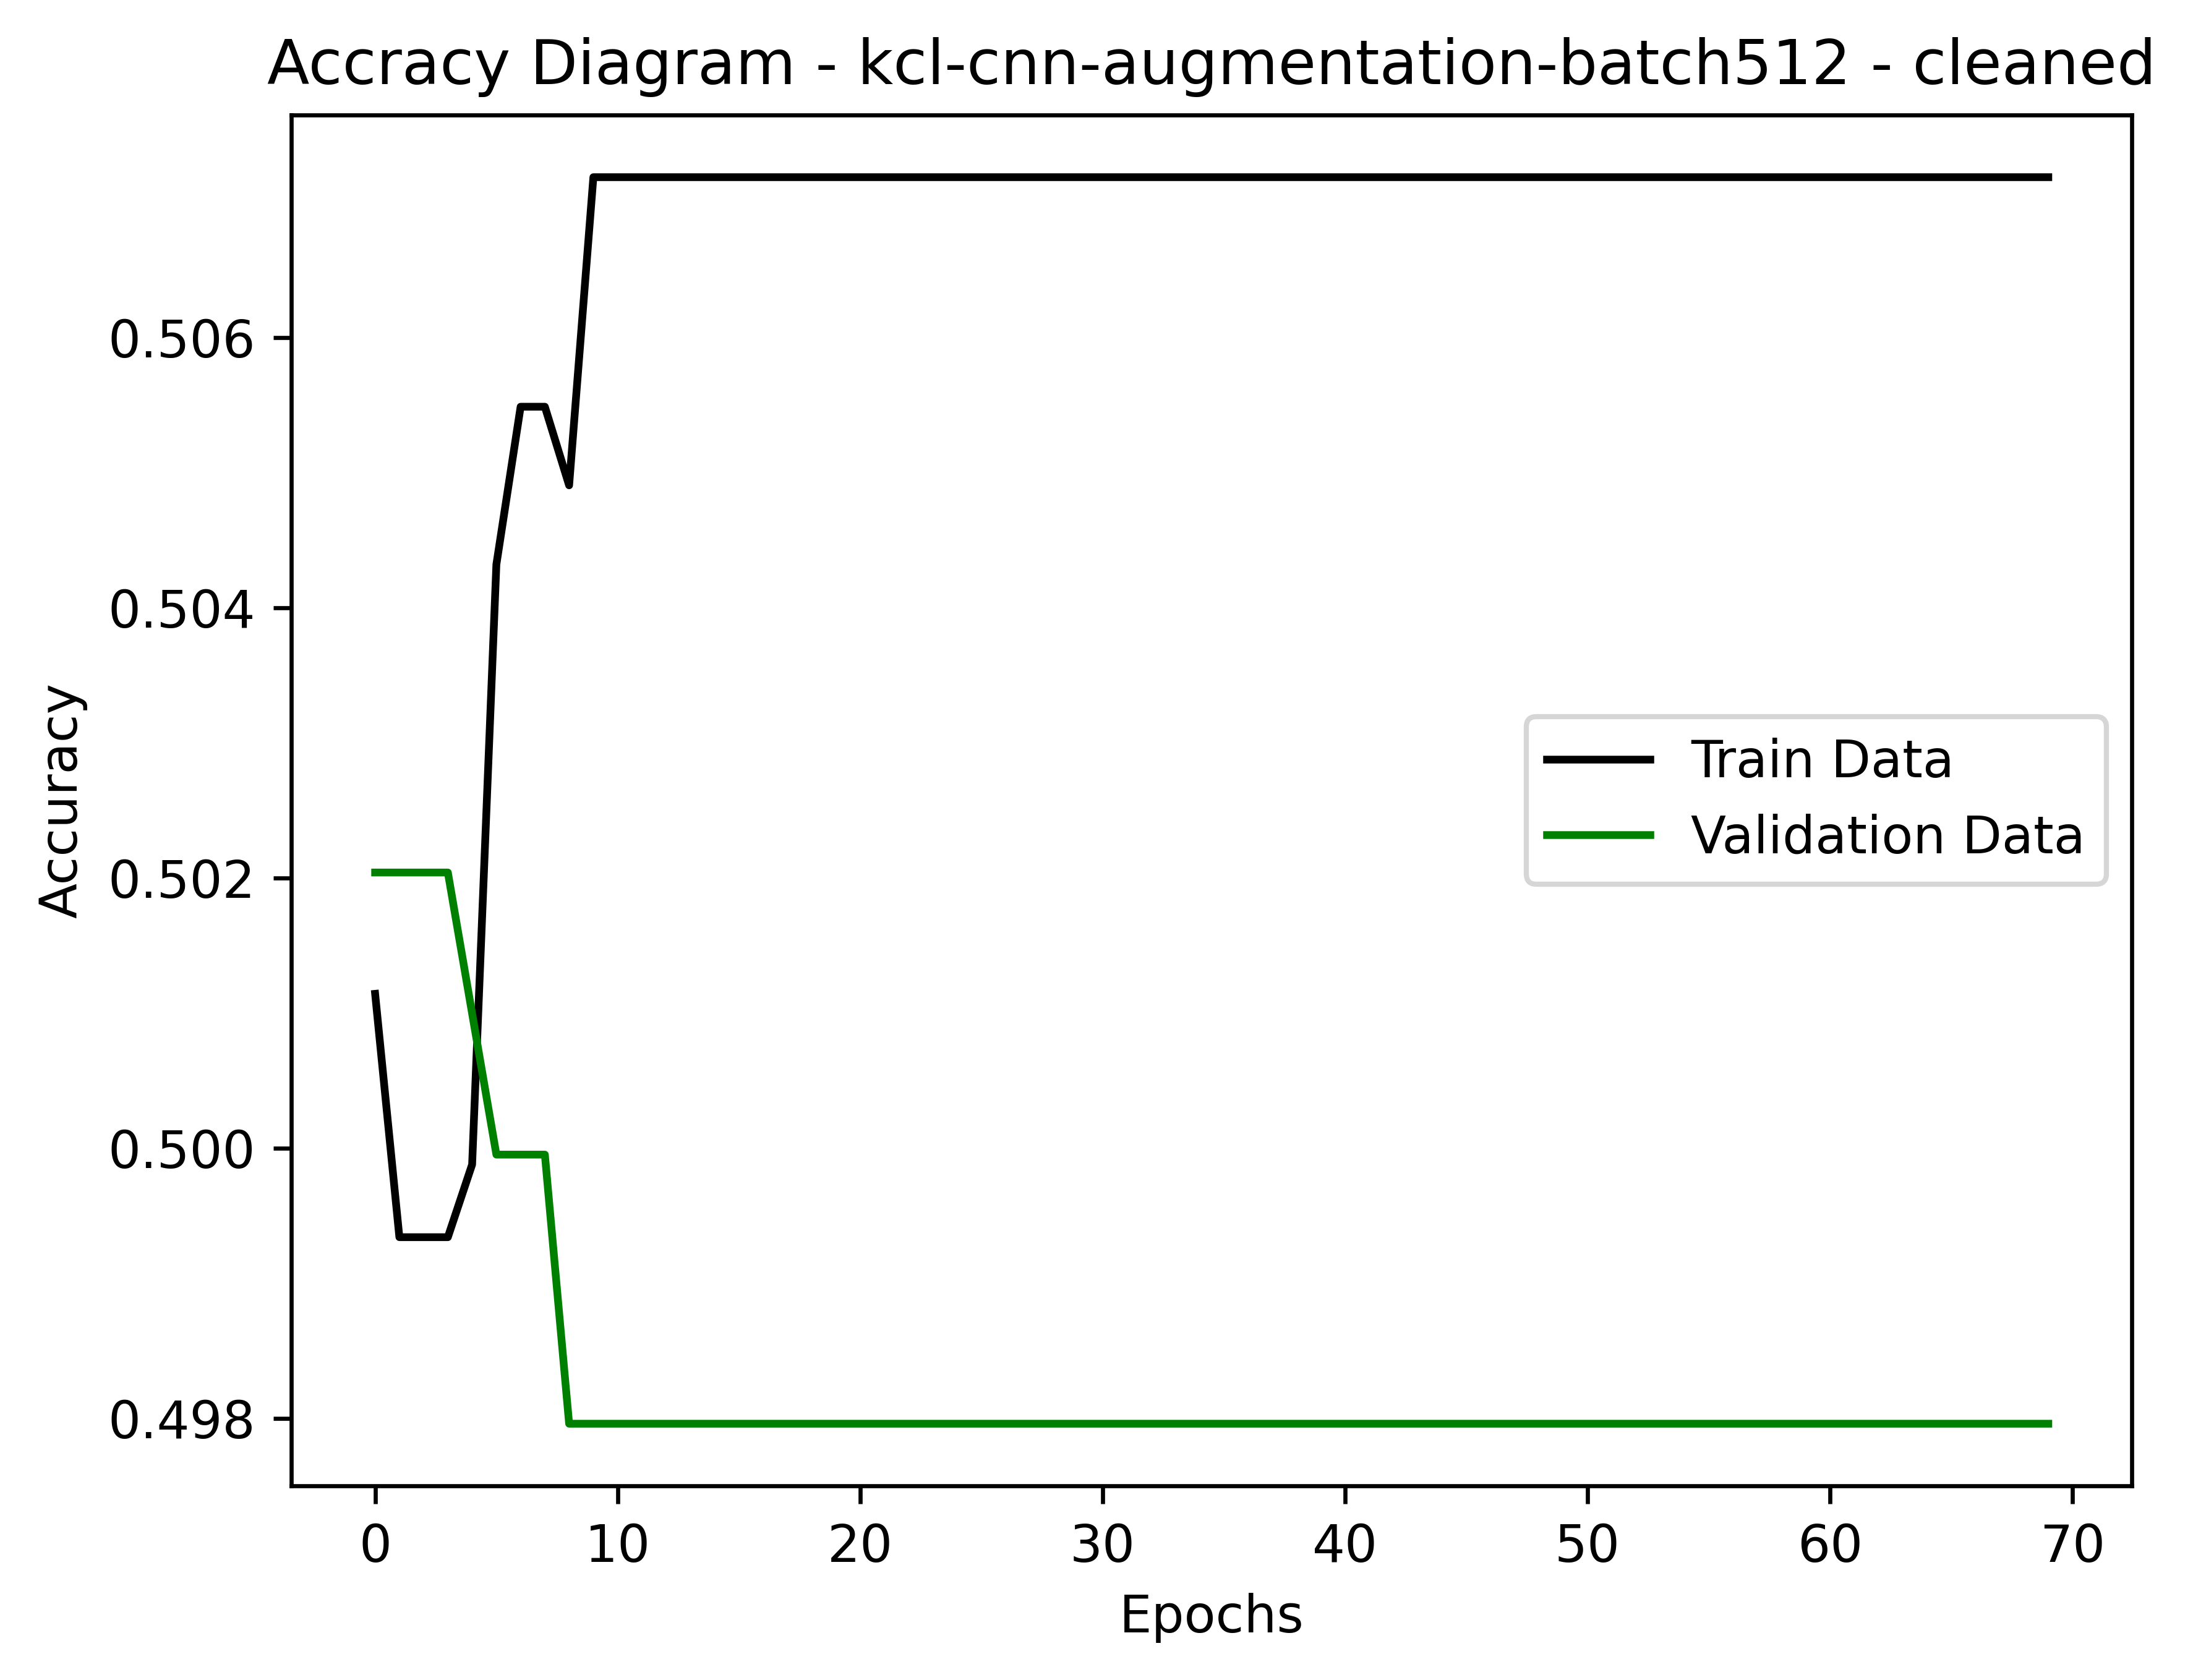

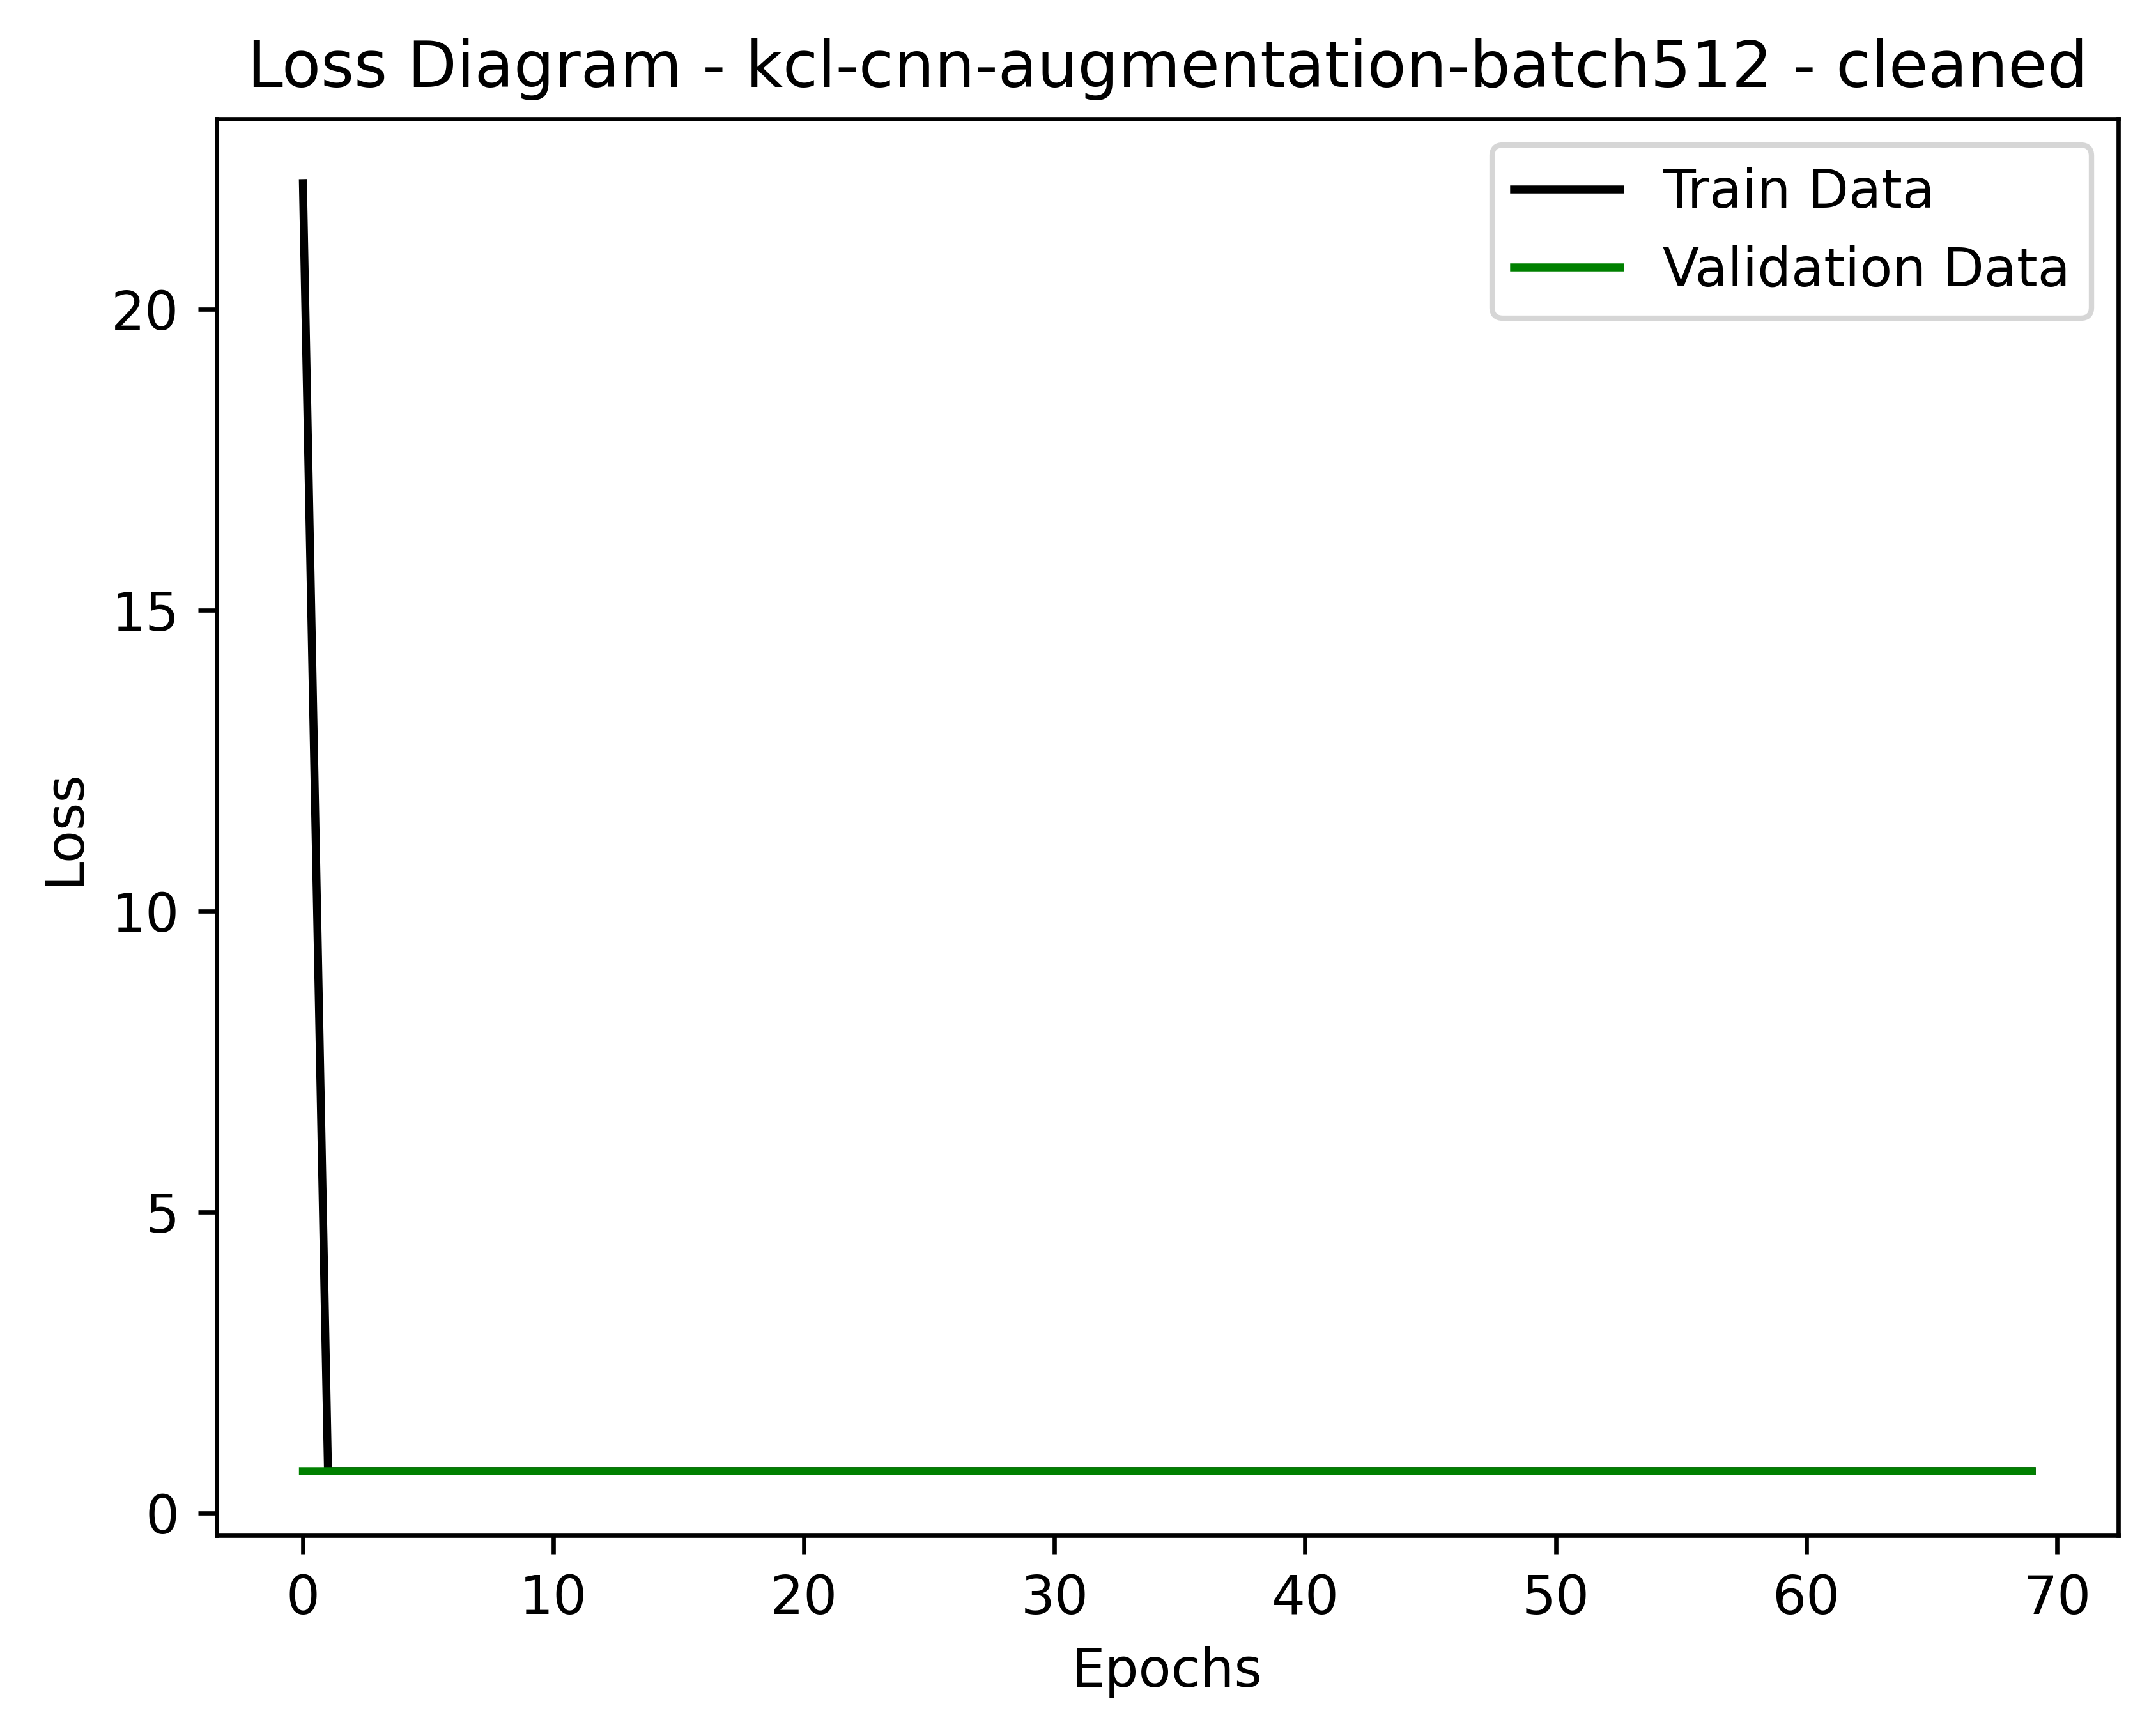

In [12]:
def NetPlot(net_histories,n_epch):
    import numpy as np
    import matplotlib.pyplot as plt

    losses=[]
    val_losses=[]
    accuracies=[]
    val_accuracies=[]

    for item in net_histories:

        history=item.history
        loss=history['loss']
        val_loss=history['val_loss']
        accuracy=history['categorical_accuracy']
        val_accuracy=history['val_categorical_accuracy']

        losses.append(loss)
        val_losses.append(val_loss)
        accuracies.append(accuracy)
        val_accuracies.append(val_accuracy)


    losses2=np.zeros((1,n_epch))
    val_losses2=np.zeros((1,n_epch))
    accuracies2=np.zeros((1,n_epch))
    val_accuracies2=np.zeros((1,n_epch))

    for i in losses:
        losses2+=i

    for i in val_losses:
        val_losses2+=i

    for i in accuracies:
        accuracies2+=i

    for i in val_accuracies:
        val_accuracies2+=i
        
    N_SPLITS = 5

    # 10 is number of folds
    losses2=(losses2/N_SPLITS).flatten()
    accuracies2=(accuracies2/N_SPLITS).flatten()
    val_losses2=(val_losses2/N_SPLITS).flatten()
    val_accuracies2=(val_accuracies2/N_SPLITS).flatten()
    
    # print('\nAccuracies: '+ str(accuracies2) +'\nLosses: '+ str(losses2))

    plt.figure('Accracy Diagram',dpi=600)
    plt.title(f'Accracy Diagram - {CNN_MODEL}-batch{BATCH_SIZE} - {DATASET_TYPE}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(accuracies2,color='black')
    plt.plot(val_accuracies2,color='green')
    plt.legend(['Train Data','Validation Data'])
    plt.savefig(f'{RESULTS_PATH}/Accuracy-Diagram-{CNN_MODEL}-batch{BATCH_SIZE}.jpg')

    plt.figure('Loss Diagram',dpi=600)
    plt.title(f'Loss Diagram - {CNN_MODEL}-batch{BATCH_SIZE} - {DATASET_TYPE}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(losses2,color='black')
    plt.plot(val_losses2,color='green')
    plt.legend(['Train Data','Validation Data'])
    plt.savefig(f'{RESULTS_PATH}/Loss-Diagram-{CNN_MODEL}-batch{BATCH_SIZE}.jpg')
    
NetPlot(lst_history,N_EPOCHS)

In [13]:
# Zipando pasta com resultados
import zipfile

def compactar_pasta(pasta, nome_arquivo_zip):
    with zipfile.ZipFile(nome_arquivo_zip, 'w', zipfile.ZIP_DEFLATED) as zip_file:
        for root, _, files in os.walk(pasta):
            for arquivo in files:
                caminho_completo = os.path.join(root, arquivo)
                zip_file.write(caminho_completo, os.path.relpath(caminho_completo, pasta))

nome_arquivo_zip = f'{VERSION}-results.zip'
compactar_pasta(RESULTS_PATH, nome_arquivo_zip)